In [14]:
import sys
sys.path.append('../')
from mlb_analytics import *
import json
import pandas as pd
import numpy as np
import plotly.express as px 
import plotly.graph_objects as go

In [37]:
power = pd.read_csv("../data/power_rankings_2025.csv")
standings = pd.read_csv("../data/standings_2025.csv")
odds = pd.read_csv("../data/odds_2025.csv")
pitching = pd.read_csv("../data/pitching_stats_2025.csv")
batting = pd.read_csv("../data/batting_stats_2025.csv")
fielding = pd.read_csv("../data/fielding_stats_2025.csv")

teams = json.load(open("../data/teams_2025.json"))
tms = json.load(open("../data/tms_2025.json"))

In [6]:
# Get the power ranking, mlb ranking, ranking diff for TOR and NYY
df1 = build_plot_table(
    power=power, 
    standings=standings, 
    selected_codes=["TOR", "NYY"], 
    team_names=teams,
    team_codes=tms, 
    mode="power"
    )

# Plot the power ranking and mlb ranking for TOR and NYY
fig = px.line(
    df1,
    x="date",
    y=df1.columns[1:],
    title="Power Rankings for TOR and NYY",
    labels={"value": "Rank", "variable": "Team"},
    color_discrete_sequence=px.colors.qualitative.Set1
)
fig.update_yaxes(autorange="reversed")  # Reverse y-axis for rankings
fig.show()

In [10]:
# Get rank change KDE and histogram data for TOR and NYY
kde_data, hist_data, peaks, _ = build_delta_kde_and_hist(
    power=power,
    standings=standings,
    team_names=teams,
    team_codes=tms,
    selected_codes=["TOR", "NYY", "BOS"],
    source="power",
    grid=np.linspace(-15, 15, 300),
    bin_edges=np.linspace(-15, 15, 31)
)
colors = px.colors.qualitative.Set1  # or whichever palette you like
color_map = dict(zip(["TOR", "NYY", "BOS"], colors))

fig = px.line(
    kde_data,
    x="x",
    y="density",
    color="team_code",
    color_discrete_map=color_map,
    title="KDE of ΔRank (Power Rankings)",
    labels={"x": "ΔRank", "density": "Density"}
)

for team_code in hist_data["team_code"].unique():
    team_hist = hist_data[hist_data["team_code"] == team_code]
    fig.add_trace(go.Bar(
        x=team_hist["x"],
        y=team_hist["pdf"],
        name=f"{team_code} Histogram",
        opacity=0.6,
        showlegend=False,
        marker_color=color_map[team_code]
    ))

# Add peak lines to the plot
for team_code, peak in peaks.items():
    fig.add_vline(
        x=peak,
        line=dict(color=color_map.get(team_code, "grey"), dash="dash"),
        annotation_text=f"Peak: {peak:.2f}",
        annotation_position="top right",
        annotation_font_color="grey"

    )
fig.show()

In [5]:
volatiliy_data = build_rank_volatility(
    power=power,
    standings=standings,
    team_names=teams,
    team_codes=tms,
    selected_codes=["TOR", "NYY"],
    source="mlb"
)

fig = px.line(
    volatiliy_data,
    x="date",
    y="sigma",
    color="team_code",
    title="Rank Volatility (MLB Rankings)",
    labels={"sigma": "Volatility", "team_code": "Team", "date": "Date"}
)

fig.show()

In [6]:
stab_df, acf_df = build_acf_stability_timeseries(
    power=power,
    standings=standings,
    team_names=teams,
    team_codes=tms,
    team_code="TOR",
    source="mlb",
    max_lag=4,
    return_acf=True,
)

fig = px.line(
    stab_df,
    x="date",
    y="value",
    color="lag",
    title="Stability (Δz) Time Series for TOR (MLB Rankings)",
    labels={"value": "Stability", "date": "Date", "lag": "Lookback (weeks)"}
)

fig.show()

fig = px.line(
    acf_df,
    x="date",
    y="value",
    color="lag",
    title="ACF Time Series for TOR (MLB Rankings)",
    labels={"value": "Consistency", "date": "Date", "lag": "Lookback (weeks)"}
)

fig.show()

c:\ProgramData\anaconda3\Lib\site-packages\numpy\lib\_function_base_impl.py:3037: RuntimeWarning:

Degrees of freedom <= 0 for slice

c:\ProgramData\anaconda3\Lib\site-packages\numpy\lib\_function_base_impl.py:2894: RuntimeWarning:

divide by zero encountered in divide

c:\ProgramData\anaconda3\Lib\site-packages\numpy\lib\_function_base_impl.py:2894: RuntimeWarning:

invalid value encountered in multiply



In [12]:
granger_df, stats = granger_power_to_mlb_report(
    power=power,
    standings=standings,
    team_names=teams,
    team_codes=tms,
    team_code="NYY",
    max_lag=6
)

# plot bar chart of p-values
fig = px.bar(
    granger_df,
    x="lag",
    y="p_value",
    title="Granger Causality Test: Power Rankings causing MLB Rankings for TOR",
    labels={"lag": "Lag (weeks)", "p_value": "p-value"}
)

fig.add_hline(
    y=0.05,
    line=dict(color="red", dash="dash"),
    annotation_text="Significance Threshold (0.05)",
    annotation_position="top right"
)

fig.show()

stats

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning:

verbose is deprecated since functions should not print results



{'team_code': 'NYY',
 'team_id': 'new-york-yankees',
 'label': 'New York Yankees',
 'n_obs_raw': 22,
 'n_obs_used': 21,
 'max_lag_requested': 6,
 'max_lag_effective': 0,
 'best_lag': 3,
 'best_p': 0.014015521848057818,
 'is_significant': True,
 'alpha': 0.05,
 'direction': 'power_to_mlb',
 'diff': 'first_difference',
 'maxlag_effective': 6}

In [9]:
stats = compute_trajectory_similarity(
    power=power,
    standings=standings,
    team_names=teams,
    team_codes=tms,
    team_code_a="TOR",
    team_code_b="NYY",
    source="mlb"
)

# Pretty print the stats
import pprint
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(stats)

{   'avg_abs_rank_gap': 7.2727272727272725,
    'corr_delta': -0.26160004033323414,
    'corr_levels': -0.33142279218780113,
    'dtw_raw': 90.0,
    'dtw_similarity_raw_0_100': 91.61230195712955,
    'dtw_similarity_z': 69.28960703760188,
    'dtw_z': 14.626190147234718,
    'overlap': 22,
    'source': 'mlb',
    'team_a': 'Toronto Blue Jays',
    'team_b': 'New York Yankees'}


In [18]:
clusters = cluster_and_summarize_season_stats(
    standings=standings,
    odds=odds,
    batting=batting,
    pitching=pitching,
    fielding=fielding,
    k=6
)

clusters

,cluster,n_teams,avg_last_mlb_rank,median_last_mlb_rank,made_playoffs,pct_playoffs,teams
0,6,5,3.600000,3.0,5,1.000000,"los-angeles-dodgers, milwaukee-brewers, new-yo..."
1,5,3,12.666667,11.0,2,0.666667,"chicago-cubs, detroit-tigers, tampa-bay-rays"
2,3,9,14.888889,15.0,3,0.333333,"cincinnati-reds, cleveland-guardians, houston-..."
3,4,7,15.142857,18.0,2,0.285714,"arizona-diamondbacks, athletics, atlanta-brave..."
4,2,4,26.250000,26.0,0,0.000000,"baltimore-orioles, chicago-whitesox, los-angel..."
5,1,2,29.000000,29.0,0,0.000000,"colorado-rockies, washington-nationals"


[199, 17, 40]
[0, 98, 65]
[218, 4, 44]
[255, 68, 0]
[220, 44, 55]
[0, 48, 138]
[35, 31, 32]
[231, 0, 25]
[255, 18, 53]
[111, 52, 0]
[5, 35, 66]
[255, 111, 11]
[0, 71, 133]
[218, 0, 28]
[0, 90, 160]
[0, 176, 242]
[0, 36, 75]
[0, 25, 63]
[255, 89, 0]
[0, 31, 72]
[255, 17, 36]
[255, 185, 0]
[47, 31, 22]
[255, 90, 16]
[0, 91, 91]
[222, 2, 13]
[9, 44, 92]
[0, 46, 123]
[0, 73, 145]
[205, 16, 65]


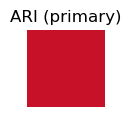

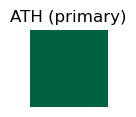

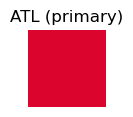

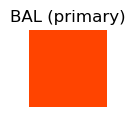

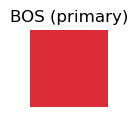

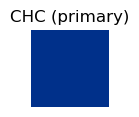

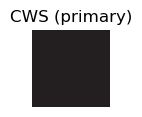

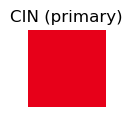

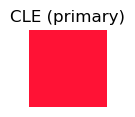

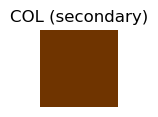

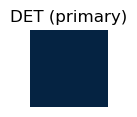

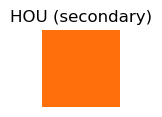

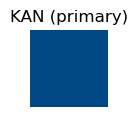

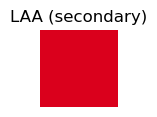

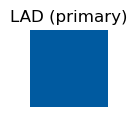

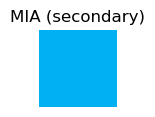

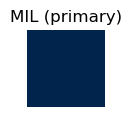

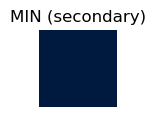

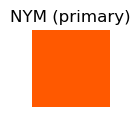

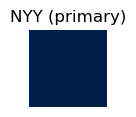

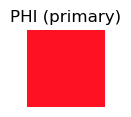

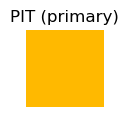

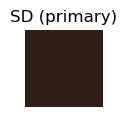

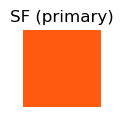

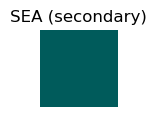

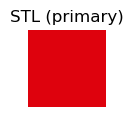

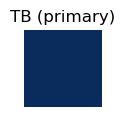

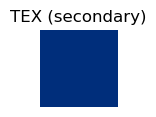

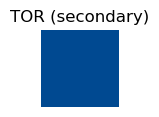

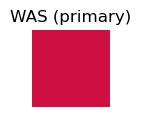

In [47]:
# Loop over all teams and get their dominant colors (first and second)
import matplotlib.pyplot as plt
import requests
from PIL import Image
from collections import Counter

team_colors = {}
for code in tms.values():
    url = f"https://a.espncdn.com/i/teamlogos/mlb/500/{code}.png"
    if code == "COL":
        url = 'https://scontent-yyz1-1.xx.fbcdn.net/v/t39.30808-6/486820054_1235960011233391_4206017060116362869_n.jpg?_nc_cat=107&ccb=1-7&_nc_sid=6ee11a&_nc_ohc=-xci1ZiB2k8Q7kNvwEJdMGS&_nc_oc=AdmirgYtn1Lzgf14UaBzgsr3p6sUFu7C-7LbrCTzdTsT_KeDzIB-0PdZzzpOs8_icGg&_nc_zt=23&_nc_ht=scontent-yyz1-1.xx&_nc_gid=WkSqg_1atxlfhq2TrxvigQ&oh=00_AfZnvgaz-uNT1D2QuErWduopVzw9BdFLw9ySkv39mttQJA&oe=68E325B2'
    try:
        image = Image.open(requests.get(url, stream=True).raw)
        image = image.resize((100, 100))
        data = np.array(image)
        data = data.reshape((-1, 4))  # reshape to a list of pixels
        data = data[data[:, 3] > 0]  # filter out fully transparent pixels
        # filter out white pixels
        data = data[~np.all(data[:, :3] > 240, axis=1)]
        if len(data) == 0:
            raise ValueError("No valid pixels found")
        most_common = Counter(map(tuple, data[:, :3])).most_common(1)[0][0]
        second_most_common = Counter(map(tuple, data[:, :3])).most_common(2)[1][0]
        team_colors[code] = {
            "primary": f"rgb{most_common}",
            "secondary": f"rgb{second_most_common}"
        }
    except Exception as e:
        print(f"Error processing {code}: {e}")
        team_colors[code] = {
            "primary": "rgb(128,128,128)",  # default grey
            "secondary": "rgb(192,192,192)" # default light grey
        }

# Color associations (whether to use primary or secondary color for each team)
color_associations = {
    "ARI": "primary",
    "ATL": "primary",
    "BAL": "primary",
    "BOS": "primary",
    "CHC": "primary",
    "CIN": "primary",
    "CLE": "primary",
    "COL": "secondary",
    "DET": "primary",
    "HOU": "secondary",
    "KAN": "primary",
    "LAA": "secondary",
    "LAD": "primary",
    "MIA": "secondary",
    "MIL": "primary",
    "MIN": "secondary",
    "NYM": "primary",
    "NYY": "primary",
    "PHI": "primary",
    "PIT": "primary",
    "SD": "primary",
    "SF": "primary",
    "SEA": "secondary",
    "STL": "primary",
    "TB": "primary",
    "TEX": "secondary",
    "TOR": "secondary",
    "WAS": "primary"
}

# store color in a json file on the basis of the association
#1. Create the object
team_color_info = {}
for code, colors in team_colors.items():
    association = color_associations.get(code, "primary")
    color = colors[association]
    # convert from rgb(np.uint8(199), np.uint8(17), np.uint8(40)) to [199, 17, 40]
    color_str = color[4:-1].replace('np.uint8(', '').replace(')', '')
    color = [int(c.strip()) for c in color_str.split(',')]
    team_color_info[code] = {
        "color": color,
        "association": association
    }

#2. Write to a json file
with open("../data/team_colors.json", "w") as f:
    json.dump(team_color_info, f, indent=4)

# double check by plotting the colors
for code, info in team_color_info.items():
    color = info["color"]
    fig, ax = plt.subplots(1, 1, figsize=(1, 1))
    ax.imshow([[color]], aspect='auto')
    ax.axis('off')
    ax.set_title(f"{code} ({info['association']})")
    plt.show()

In [27]:
powerx = prepare_power_features_for_hmm(power)
states_df, meta_stats = fit_team_hmm(
    power=power,
    team_code="TOR",
    team_codes=tms,
    team_names=teams,
    power_features=powerx,
)

import pprint
# Pretty print the meta_stats
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(meta_stats)
states_df

# Plot time series of ranks colored by state
import plotly.express as px
import plotly.graph_objects as go

# Get TOR ranks and merge with states
tor_ranks = power[power["team_id"] == "toronto-bluejays"][["date", "rank"]].copy()
tor_ranks["date"] = pd.to_datetime(tor_ranks["date"], errors="coerce").dt.tz_localize(None).dt.normalize()

# If states_df has date as index, bring it out first
if "date" not in states_df.columns:
    states_df = states_df.reset_index()

states_df["date"] = pd.to_datetime(states_df["date"], errors="coerce").dt.tz_localize(None).dt.normalize()

# Now the merge will work
tor_ranks = tor_ranks.merge(states_df[["date", "state"]], on="date", how="left")

# First: add the continuous line (no coloring by state, just one line)
state_color_map = {
    0: "#77DD77",  # pastel green
    1: "#FDFD96",  # pastel yellow
    2: "#FF6961"   # pastel red
}

# Continuous black line
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=tor_ranks["date"],
    y=tor_ranks["rank"],
    mode="lines",
    line=dict(color="black"),
    name="Rank",
    opacity=0.5
))

# Markers colored by state
fig.add_trace(go.Scatter(
    x=tor_ranks["date"],
    y=tor_ranks["rank"],
    mode="markers",
    marker=dict(
        size=10,
        line=dict(width=1, color="DarkSlateGrey"),
        color=tor_ranks["state"].map(state_color_map),  # map ints → colors
    ),
    name="State"
))

# Reverse y-axis so rank 1 is on top
fig.update_yaxes(autorange="reversed")

fig.update_layout(
    title="TOR Rankings Over Time",
    xaxis_title="Date",
    yaxis_title="Rank"
)

fig.show()

Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


{   'P':                   Good      Mediocre           Bad
Good      3.783430e-01  6.216570e-01  1.933294e-08
Mediocre  2.296239e-12  4.024183e-09  1.000000e+00
Bad       8.287863e-01  1.712136e-01  6.174736e-08,
    'init': 'quant',
    'means':           level_dev     chg_z    mom3_z
Good       0.231411  1.307326  0.939338
Mediocre   0.019126 -0.771933 -0.003954
Bad       -0.263665 -0.487563 -0.389979,
    'n_used': 21,
    'pi':            Good      Mediocre  Bad
0  1.698838e-18  2.674288e-35  1.0}


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



In [25]:
# All checks passed!

Most dominant color for TOR: (np.uint8(248), np.uint8(0), np.uint8(48))
Second most dominant color for TOR: (np.uint8(0), np.uint8(73), np.uint8(145))


(np.float64(-0.5), np.float64(9.5), np.float64(9.5), np.float64(-0.5))

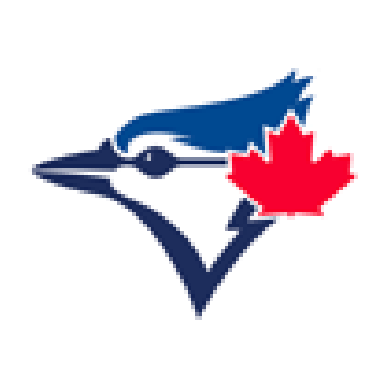

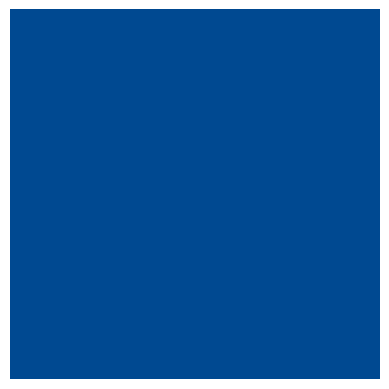

In [8]:
# load an image and find the most dominant color
from PIL import Image
from collections import Counter
import numpy as np
import requests
import matplotlib.pyplot as plt

code = 'TOR'
url = f"https://a.espncdn.com/i/teamlogos/mlb/500/{code}.png"

image = Image.open(requests.get(url, stream=True).raw)
image = image.resize((100, 100))
data = np.array(image)
data = data.reshape((-1, 4))  # reshape to a list of pixels
data = data[data[:, 3] > 0]  # filter out fully transparent pixels
# filter out white pixels
data = data[~np.all(data[:, :3] > 240, axis=1)]

most_common = Counter(map(tuple, data[:, :3])).most_common(1)[0][0]
second_most_common = Counter(map(tuple, data[:, :3])).most_common(2)[1][0]
print(f"Most dominant color for {code}: {most_common}")
print(f"Second most dominant color for {code}: {second_most_common}")
